<a href="https://colab.research.google.com/github/KW-ML/ML_Project/blob/main/code/Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (47.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import pandas as pd
from numpy import hstack,zeros,ones,set_printoptions
from numpy.random import rand, randn, randint

#Set some numpy print options for displaying numpy arrays to fit maximum width of cell
set_printoptions(precision=3, edgeitems=30, linewidth=1000,formatter=dict(float=lambda x: "%.6g" % x)) 

# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

# Disable Warnings for chained assignments Eg:Setting with Copy Warning
pd.options.mode.chained_assignment = None 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import math
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler
# Common MinMaxScaler for all features.
minmaxscaler = MinMaxScaler()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('font', family='NanumBarunGothic')



In [ ]:
train_low = pd.read_csv("/content/drive/MyDrive/기계학습팀플/코드/data/train_low.csv", encoding = 'utf-8-sig')
test_low =pd.read_csv("/content/drive/MyDrive/기계학습팀플/코드/data/test_low.csv", encoding = 'utf-8-sig')
train_high= pd.read_csv("/content/drive/MyDrive/기계학습팀플/코드/data/train_high.csv", encoding = 'utf-8-sig')
test_high= pd.read_csv("/content/drive/MyDrive/기계학습팀플/코드/data/test_high.csv", encoding = 'utf-8-sig')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Common MinMaxScaler for all features.
scaler = MinMaxScaler()
# Rescale Data
colnames_all = list(train_low)
train_low[colnames_all] = scaler.fit_transform(train_low[colnames_all])
print('Rescaled Input Dataframe:')
train_low.tail()

Rescaled Input Dataframe:


,시설용량,생물학적,고도,유입하수량,생물학적 유입하수량,고도 유입하수량,방류량,생물학적 방류량,고도 방류량,유입 COD,...,수계_0,수계_1,수계_2,준공일_day,가동개시일_day,방류수소독방법_염소,방류수소독방법_자외선,방류수소독방법_오존,방류수소독방법_기타,처리효율
106,0.000225,0.000000,0.000255,0.000213,0.000000,0.000236,0.000270,0.000000,0.000270,0.406446,...,1.0,0.0,1.0,0.255872,0.261132,1.0,1.0,1.0,1.0,0.963554
107,0.000044,0.066667,0.000000,0.000009,0.039764,0.000000,0.000036,0.039764,0.000000,0.112802,...,0.0,1.0,0.0,0.731053,0.736560,1.0,1.0,1.0,1.0,0.993166
108,0.000116,0.000000,0.000145,0.000186,0.000000,0.000208,0.000239,0.000000,0.000239,0.293644,...,1.0,0.0,0.0,0.395591,0.407967,1.0,1.0,1.0,1.0,0.943052
109,0.000135,0.000000,0.000164,0.000140,0.000000,0.000162,0.000186,0.000000,0.000186,0.290958,...,0.0,1.0,1.0,0.378563,0.391288,1.0,1.0,1.0,1.0,0.981777
110,0.000189,0.000000,0.000218,0.000171,0.000000,0.000193,0.000222,0.000000,0.000222,0.544315,...,0.0,1.0,0.0,0.263170,0.278258,1.0,1.0,1.0,1.0,0.949886


In [ ]:
nr_features = train_low.shape[1]
print('Length of DataFrame:',train_low.shape[0])
print('No. of features:',nr_features)

Length of DataFrame: 111
No. of features: 56


In [ ]:
# Select a batch of random samples, returns features and target
def generate_real_samples(dataset, n_samples):
	# choose random instances of indices
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve samples from indices
	X = dataset.iloc[ix].values
	# generate 'real' class labels (1)
	y = ones((n_samples,1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n)
  # predict outputs
  X = generator.predict(x_input)
  # create class labels
  y = zeros((n, 1))
  return X, y

### Create a Generative Adversarial Network to model multivariate function:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# define the standalone discriminator model
def define_discriminator(n_inputs=nr_features):
  model = Sequential()
  model.add(Dense(n_inputs, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=nr_features):
  model = Sequential()
  model.add(Dense(latent_dim, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(Dense(64,activation = 'relu'))
  model.add(Dense(n_outputs, activation='linear'))
  return model
 
# Composite Model - define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

nr_samples = 4 # Select smaller value when using the LTR dataframe with only 34 data points as 'real_data'

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, dataset, generator, discriminator, latent_dim, n=nr_samples):
  # prepare real samples
  x_real, y_real = generate_real_samples(dataset, n)
  # evaluate discriminator on real examples
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
  # evaluate discriminator on fake examples
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('Epoch:',epoch,'Accuracy(RealData):', round(acc_real,3),'Accuracy(FakeData):', round(acc_fake,3))
  original_data = scaler.inverse_transform(x_real)
  synthetic_data = scaler.inverse_transform(x_fake)
#   print("Original_data  = %s" % original_data)
#   print("Synthetic_data  = %s" % synthetic_data)
  # Scatter plot of real and fake data points
  plt.scatter(original_data[:, 0], original_data[:, -1], color='red',label = 'Real Data')
  plt.scatter(synthetic_data[:, 0], synthetic_data[:, -1], color='blue', label = 'Synthesized Data')
  plt.ylabel("처리효율")
  plt.xlabel("시설용량")
  plt.legend(loc="upper left")
  plt.show()

batch_size = 12

  # train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=batch_size, n_eval=500):
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)
  # prepare lists for storing stats each iteration
  disc_rd_hist, disc_fd_hist, g_hist, acc1_hist, acc2_hist = list(), list(), list(), list(), list()
	# manually enumerate epoch
  for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(train_low,half_batch)
    # Update discriminator
    d_loss1, d_acc1 = d_model.train_on_batch(x_real, y_real)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_loss2, d_acc2 = d_model.train_on_batch(x_fake, y_fake)
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator's error
    g_loss = gan_model.train_on_batch(x_gan, y_gan)
    # summarize loss on this batch for every epoch
#     print('>%d, disc_loss_real=%.3f, disc_loss_fake=%.3f gen_loss=%.3f, disc_acc_real=%d, disc_acc_fake=%d'
#           %(i+1, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
    # record history
    disc_rd_hist.append(d_loss1)
    disc_fd_hist.append(d_loss2)
    g_hist.append(g_loss)
    acc1_hist.append(d_acc1)
    acc2_hist.append(d_acc2)
    # evaluate the model every n_eval epochs
    if (i+1) % n_eval == 0:      
      # Summarize Loss every n_eval epochs
      print('Epoch:%d, disc_loss_real=%.3f, disc_loss_fake=%.3f gen_loss=%.3f, disc_acc_real=%d, disc_acc_fake=%d'
            %(i, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
      summarize_performance(i,train_low, g_model, d_model, latent_dim) 
  return disc_rd_hist, disc_fd_hist, g_hist, acc1_hist, acc2_hist

Epoch:499, disc_loss_real=0.057, disc_loss_fake=0.649 gen_loss=1.551, disc_acc_real=100, disc_acc_fake=50
Epoch: 499 Accuracy(RealData): 1.0 Accuracy(FakeData): 1.0


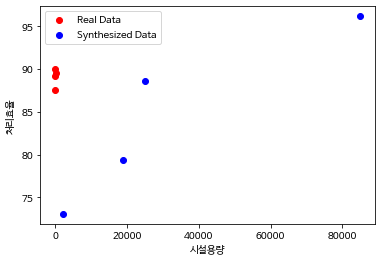

Epoch:999, disc_loss_real=0.921, disc_loss_fake=0.411 gen_loss=1.250, disc_acc_real=50, disc_acc_fake=100
Epoch: 999 Accuracy(RealData): 1.0 Accuracy(FakeData): 0.5


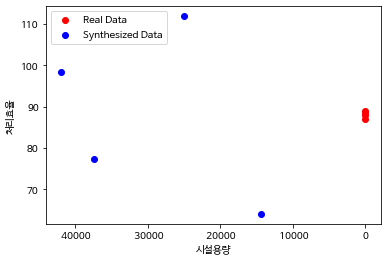

Epoch:1499, disc_loss_real=0.736, disc_loss_fake=0.437 gen_loss=1.290, disc_acc_real=50, disc_acc_fake=83
Epoch: 1499 Accuracy(RealData): 0.5 Accuracy(FakeData): 1.0


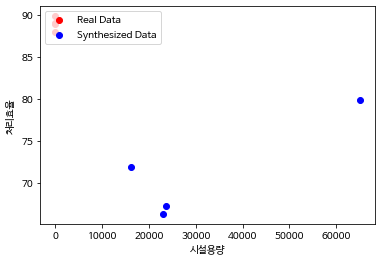

Epoch:1999, disc_loss_real=0.299, disc_loss_fake=0.650 gen_loss=1.120, disc_acc_real=100, disc_acc_fake=66
Epoch: 1999 Accuracy(RealData): 0.75 Accuracy(FakeData): 0.5


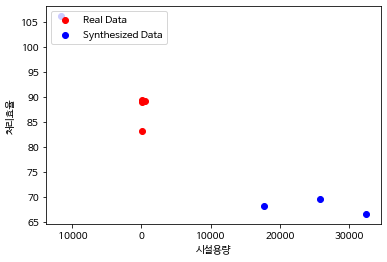

Epoch:2499, disc_loss_real=0.253, disc_loss_fake=0.409 gen_loss=1.139, disc_acc_real=100, disc_acc_fake=100
Epoch: 2499 Accuracy(RealData): 0.75 Accuracy(FakeData): 1.0


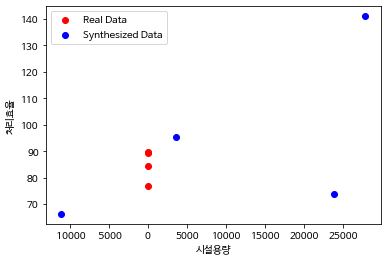

Epoch:2999, disc_loss_real=0.355, disc_loss_fake=0.713 gen_loss=1.001, disc_acc_real=83, disc_acc_fake=33
Epoch: 2999 Accuracy(RealData): 1.0 Accuracy(FakeData): 0.75


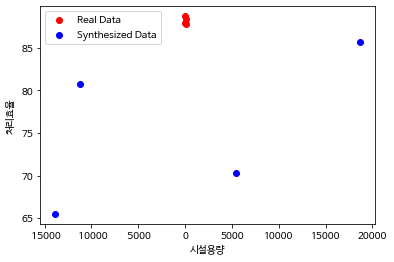

Epoch:3499, disc_loss_real=0.505, disc_loss_fake=0.485 gen_loss=1.259, disc_acc_real=83, disc_acc_fake=83
Epoch: 3499 Accuracy(RealData): 0.75 Accuracy(FakeData): 1.0


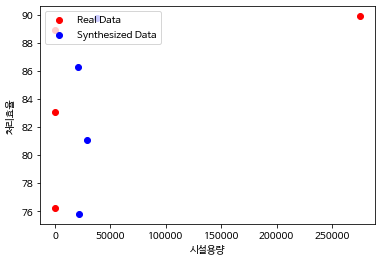

Epoch:3999, disc_loss_real=0.322, disc_loss_fake=0.397 gen_loss=1.216, disc_acc_real=83, disc_acc_fake=83
Epoch: 3999 Accuracy(RealData): 1.0 Accuracy(FakeData): 1.0


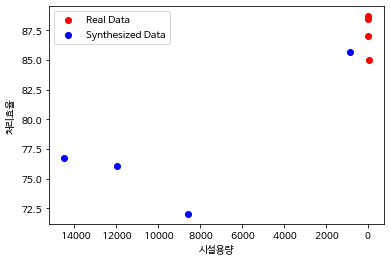

Epoch:4499, disc_loss_real=0.419, disc_loss_fake=0.579 gen_loss=1.361, disc_acc_real=83, disc_acc_fake=66
Epoch: 4499 Accuracy(RealData): 0.25 Accuracy(FakeData): 1.0


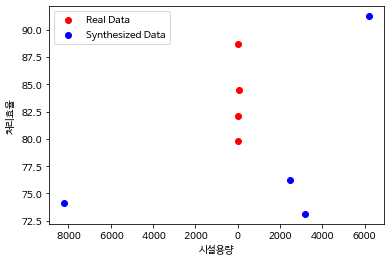

Epoch:4999, disc_loss_real=0.338, disc_loss_fake=0.357 gen_loss=1.126, disc_acc_real=83, disc_acc_fake=83
Epoch: 4999 Accuracy(RealData): 1.0 Accuracy(FakeData): 1.0


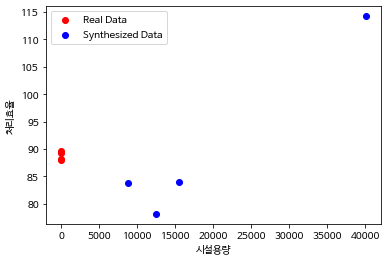

Epoch:5499, disc_loss_real=0.561, disc_loss_fake=0.225 gen_loss=1.905, disc_acc_real=50, disc_acc_fake=83
Epoch: 5499 Accuracy(RealData): 1.0 Accuracy(FakeData): 1.0


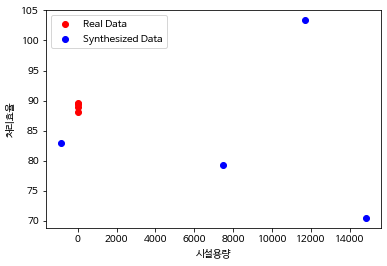

Epoch:5999, disc_loss_real=0.303, disc_loss_fake=0.241 gen_loss=1.451, disc_acc_real=83, disc_acc_fake=83
Epoch: 5999 Accuracy(RealData): 0.75 Accuracy(FakeData): 1.0


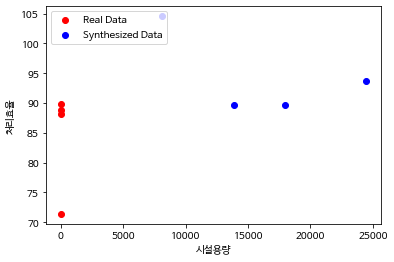

Epoch:6499, disc_loss_real=0.217, disc_loss_fake=0.475 gen_loss=2.014, disc_acc_real=100, disc_acc_fake=83
Epoch: 6499 Accuracy(RealData): 0.75 Accuracy(FakeData): 0.75


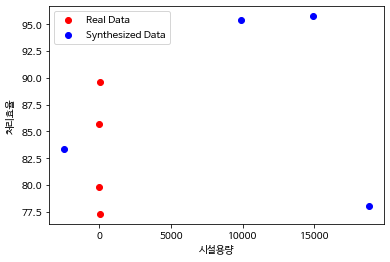

Epoch:6999, disc_loss_real=0.295, disc_loss_fake=0.220 gen_loss=1.574, disc_acc_real=83, disc_acc_fake=100
Epoch: 6999 Accuracy(RealData): 0.75 Accuracy(FakeData): 1.0


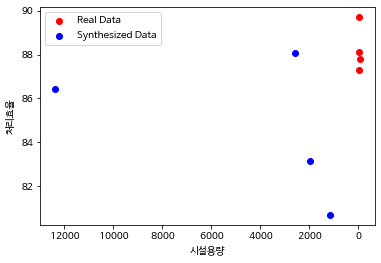

Epoch:7499, disc_loss_real=0.235, disc_loss_fake=0.393 gen_loss=1.564, disc_acc_real=83, disc_acc_fake=100
Epoch: 7499 Accuracy(RealData): 0.5 Accuracy(FakeData): 1.0


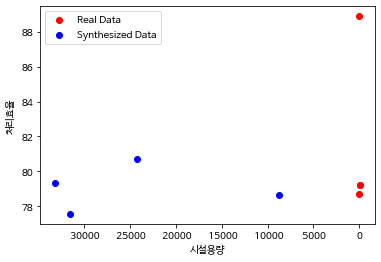

Epoch:7999, disc_loss_real=0.394, disc_loss_fake=0.151 gen_loss=2.543, disc_acc_real=83, disc_acc_fake=100
Epoch: 7999 Accuracy(RealData): 1.0 Accuracy(FakeData): 1.0


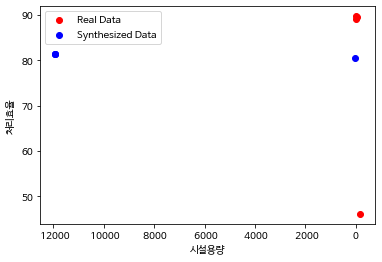

Epoch:8499, disc_loss_real=0.497, disc_loss_fake=0.313 gen_loss=2.163, disc_acc_real=83, disc_acc_fake=100
Epoch: 8499 Accuracy(RealData): 0.5 Accuracy(FakeData): 1.0


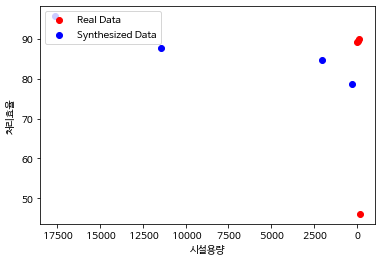

Epoch:8999, disc_loss_real=0.477, disc_loss_fake=0.292 gen_loss=1.941, disc_acc_real=66, disc_acc_fake=100
Epoch: 8999 Accuracy(RealData): 1.0 Accuracy(FakeData): 0.75


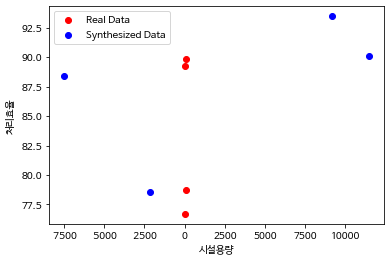

Epoch:9499, disc_loss_real=0.642, disc_loss_fake=0.197 gen_loss=2.389, disc_acc_real=83, disc_acc_fake=100
Epoch: 9499 Accuracy(RealData): 1.0 Accuracy(FakeData): 1.0


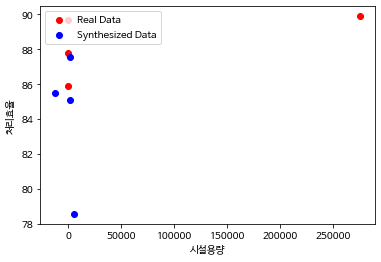

Epoch:9999, disc_loss_real=0.202, disc_loss_fake=0.278 gen_loss=2.236, disc_acc_real=100, disc_acc_fake=100
Epoch: 9999 Accuracy(RealData): 1.0 Accuracy(FakeData): 0.75


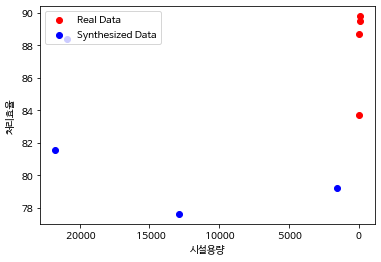

In [ ]:
# size of the latent space
latent_dim = 20
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
disc_rd_hist, disc_fd_hist, g_hist, acc1_hist, acc2_hist = train(generator, discriminator, gan_model, latent_dim)

In [ ]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
  # plot loss
  fig = plt.figure(figsize=(16,12))
  ax1 = plt.subplot(2, 1, 1)
  ax1.plot(d1_hist, label='d-real')
  ax1.plot(d2_hist, label='d-fake')
  ax1.plot(g_hist, label='gen')
  ax1.legend()
  # plot discriminator accuracy
  ax2 = plt.subplot(2, 1, 2)
  ax2.plot(a1_hist, label='acc-real')
  ax2.plot(a2_hist, label='acc-fake')
  ax2.legend()


"  plt.savefig('/content/drive/MyDrive/기계학습팀플/코드/data/plots/GAN_Training_loss.png')\n  plt.close() "

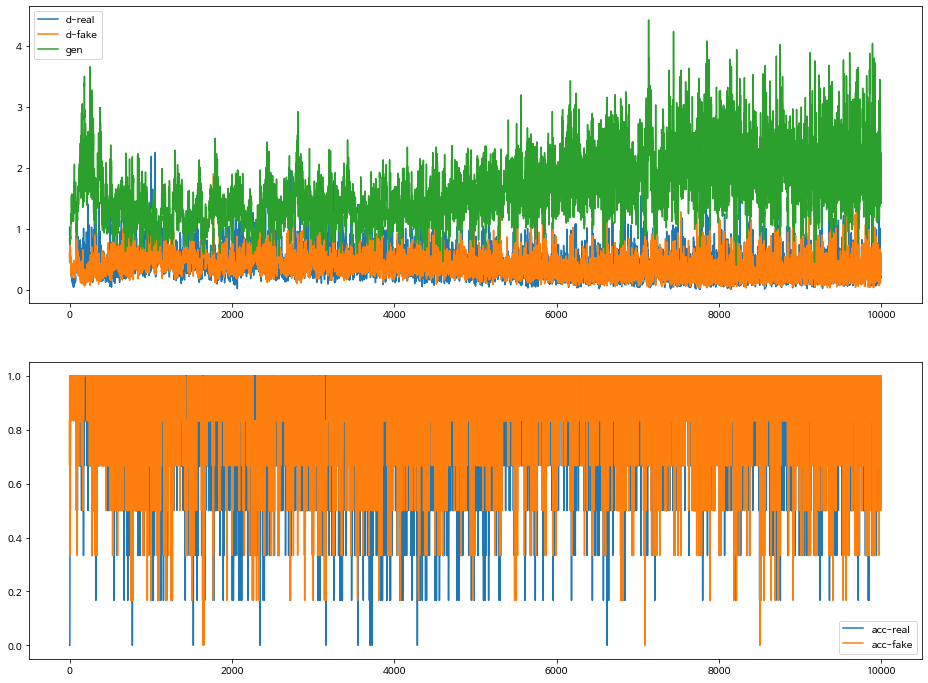

In [ ]:
plot_history(disc_rd_hist, disc_fd_hist, g_hist, acc1_hist, acc2_hist)

### Synthesise Artificial data with trained Generator

In [ ]:
X_syn_scaled,_ = generate_fake_samples(generator, latent_dim, n=3297)
X_synthesised = scaler.inverse_transform(X_syn_scaled)
df_syn = pd.DataFrame(data = X_synthesised, columns = colnames_all)

In [ ]:
# Print synthesised dataframe containing synthetic data from GAN
df_syn

,시설용량,생물학적,고도,유입하수량,생물학적 유입하수량,고도 유입하수량,방류량,생물학적 방류량,고도 방류량,유입 COD,...,수계_0,수계_1,수계_2,준공일_day,가동개시일_day,방류수소독방법_염소,방류수소독방법_자외선,방류수소독방법_오존,방류수소독방법_기타,처리효율
0,-12601.278320,-6.154983,-7934.032715,6996.544434,1.678272,-3691.609619,10771.091797,12.723790,6268.066895,52.971710,...,0.791521,0.017367,0.946779,5747.187012,4811.075195,0.996311,0.922292,1.004025,0.911113,85.789337
1,-17746.724609,-8.881196,-7927.604980,7253.836426,8.036355,-1406.596680,9367.661133,17.390465,6584.457031,53.673363,...,0.679233,0.009528,0.864064,5685.283691,4625.067871,0.954323,0.916281,0.964450,0.858933,85.325821
2,-22023.673828,2.323529,-6679.566406,6984.611328,4.696116,-1240.537109,13146.016602,23.225824,4805.176758,3.344222,...,-0.172919,1.059536,-0.101905,5705.144043,4706.660645,1.012725,1.001028,1.042446,1.029175,82.438377
3,-19815.605469,4.367341,-12379.318359,7874.338379,0.849652,-6962.003906,14734.362305,16.426727,6688.865723,10.773025,...,-0.020409,0.742171,-0.008226,4897.406738,3678.460693,0.924650,0.788789,0.876041,0.899032,80.383476
4,-11856.433594,-7.087183,-14171.494141,6783.041992,4.645905,-6003.703125,20811.671875,23.419100,14899.173828,19.068886,...,-0.034314,0.781045,0.167033,4091.874756,3229.349854,0.919779,0.764634,0.900642,1.085570,77.470604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,-8523.688477,-5.901518,-14158.648438,8672.248047,6.975634,-11233.625000,12249.270508,11.862405,16075.333984,17.007692,...,-0.222330,0.824554,0.105740,4720.519531,3815.874512,0.650823,0.655250,0.660189,0.732367,72.751610
3293,-14069.362305,-7.020809,-15450.409180,10685.274414,1.375227,-6913.373047,21449.257812,22.661104,17441.148438,12.767714,...,-0.052558,0.861948,0.096397,3979.270508,3659.257324,0.932028,0.743052,0.904960,1.084372,78.396774
3294,-21980.904297,4.896886,-7747.506348,6387.575195,2.616755,-2796.401367,13121.621094,19.222193,3088.460205,7.411426,...,-0.081184,0.889751,-0.048592,5551.094238,4205.860352,0.988324,0.932160,0.988860,0.949036,81.922508
3295,-21953.613281,5.832959,-8143.936523,6176.631348,1.857369,-3358.435303,13104.368164,17.761395,2455.318848,8.909502,...,-0.047490,0.827542,-0.028842,5493.318848,4024.192871,0.979357,0.907031,0.969265,0.919816,81.729965


In [ ]:
df_syn

,시설용량,생물학적,고도,유입하수량,생물학적 유입하수량,고도 유입하수량,방류량,생물학적 방류량,고도 방류량,유입 COD,...,수계_0,수계_1,수계_2,준공일_day,가동개시일_day,방류수소독방법_염소,방류수소독방법_자외선,방류수소독방법_오존,방류수소독방법_기타,처리효율
0,-12601.278320,-6.154983,-7934.032715,6996.544434,1.678272,-3691.609619,10771.091797,12.723790,6268.066895,52.971710,...,0.791521,0.017367,0.946779,5747.187012,4811.075195,0.996311,0.922292,1.004025,0.911113,85.789337
1,-17746.724609,-8.881196,-7927.604980,7253.836426,8.036355,-1406.596680,9367.661133,17.390465,6584.457031,53.673363,...,0.679233,0.009528,0.864064,5685.283691,4625.067871,0.954323,0.916281,0.964450,0.858933,85.325821
2,-22023.673828,2.323529,-6679.566406,6984.611328,4.696116,-1240.537109,13146.016602,23.225824,4805.176758,3.344222,...,-0.172919,1.059536,-0.101905,5705.144043,4706.660645,1.012725,1.001028,1.042446,1.029175,82.438377
3,-19815.605469,4.367341,-12379.318359,7874.338379,0.849652,-6962.003906,14734.362305,16.426727,6688.865723,10.773025,...,-0.020409,0.742171,-0.008226,4897.406738,3678.460693,0.924650,0.788789,0.876041,0.899032,80.383476
4,-11856.433594,-7.087183,-14171.494141,6783.041992,4.645905,-6003.703125,20811.671875,23.419100,14899.173828,19.068886,...,-0.034314,0.781045,0.167033,4091.874756,3229.349854,0.919779,0.764634,0.900642,1.085570,77.470604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,-8523.688477,-5.901518,-14158.648438,8672.248047,6.975634,-11233.625000,12249.270508,11.862405,16075.333984,17.007692,...,-0.222330,0.824554,0.105740,4720.519531,3815.874512,0.650823,0.655250,0.660189,0.732367,72.751610
3293,-14069.362305,-7.020809,-15450.409180,10685.274414,1.375227,-6913.373047,21449.257812,22.661104,17441.148438,12.767714,...,-0.052558,0.861948,0.096397,3979.270508,3659.257324,0.932028,0.743052,0.904960,1.084372,78.396774
3294,-21980.904297,4.896886,-7747.506348,6387.575195,2.616755,-2796.401367,13121.621094,19.222193,3088.460205,7.411426,...,-0.081184,0.889751,-0.048592,5551.094238,4205.860352,0.988324,0.932160,0.988860,0.949036,81.922508
3295,-21953.613281,5.832959,-8143.936523,6176.631348,1.857369,-3358.435303,13104.368164,17.761395,2455.318848,8.909502,...,-0.047490,0.827542,-0.028842,5493.318848,4024.192871,0.979357,0.907031,0.969265,0.919816,81.729965


In [ ]:
# features/target, train/test dataset 분리

test = pd.concat([test_high,test_low])
train = pd.concat([train_high,df_syn])
train_X = train[train.columns.difference(['처리효율'])]
train_y = train["처리효율"]

test_X = test[test.columns.difference(['처리효율'])]
test_y = test["처리효율"]


train.to_csv("/content/drive/MyDrive/기계학습팀플/코드/data/train_gan.csv", encoding = 'utf-8-sig', index = False)

